# Semantic Segmentation

## FCN with Resnet-101 backbone

FCN- Fully Convolutional Networks, are among the most early invented Neural Networks for the task of Semantic Segmentation

In [24]:
import os
import subprocess

import torch
import torchvision
from torchvision import models

from PIL import Image
import matplotlib.pyplot as plt

import requests
import time
import numpy as np
plt.style.use('fivethirtyeight')


In [3]:
# load the FCN ResNet101 model segmenation model
fcn = models.segmentation.fcn_resnet101(weights= torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\jsrinivasan/.cache\torch\hub\checkpoints\fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:14<00:00, 15.0MB/s] 


In [19]:
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading {url} to {save_name}")
        subprocess.run(['curl', url, '-o', save_name])

In [20]:
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

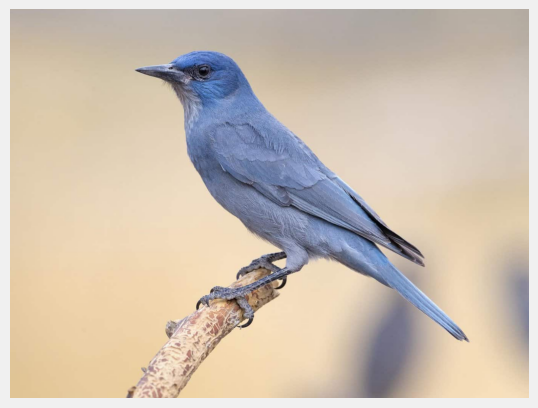

In [21]:
download_file(
    r'https://learnopencv.com/wp-content/uploads/2022/10/bird.jpg',
    save_name=os.path.join(inference_dir, 'bird.jpg')
)
img = Image.open(os.path.join(inference_dir, 'bird.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

1. need to preprocess
    - Resize to 256x 256
    - center crop to  224 x 224
    - convert it to tensor
    - normlaize it using mean and std
2. get it ready as batch


In [ ]:
import torchvision.transforms as T

trf = T.Compose([T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                        mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
                 ]) # mean and std values are from the ImageNet dataset
inp = trf(img).unsqueeze(0)               

In [23]:
# pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [26]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy() # removes the computational graph and converts to numpy array
print (om.shape)
np.unique(om)

(224, 224)


array([0, 3])

In [27]:
# decode the output
def decode_segmap(image, nc = 21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image, dtype=np.uint8)
    g = np.zeros_like(image, dtype=np.uint8)
    b = np.zeros_like(image, dtype=np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r,g,b], axis = 2)
    return rgb


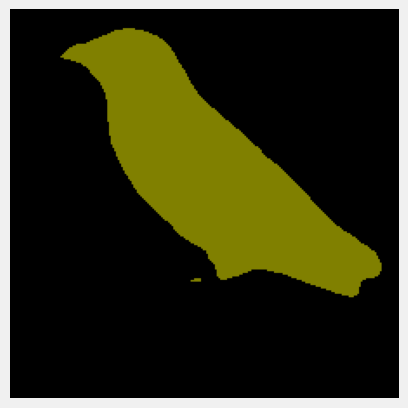

In [29]:
rgb = decode_segmap(om)
#plt.figure(figsize=(12,9))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [41]:
def segment(net, path, show_orig=True, dev='cuda'):
    plt.figure(figsize=(10, 7))
    img = Image.open(path).convert('RGB')
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

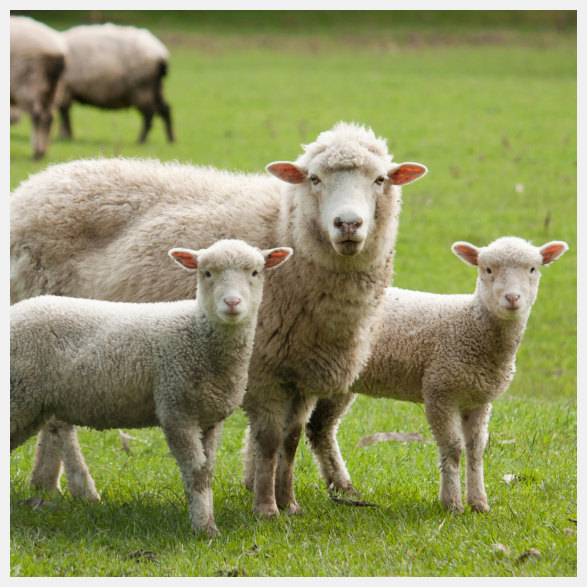

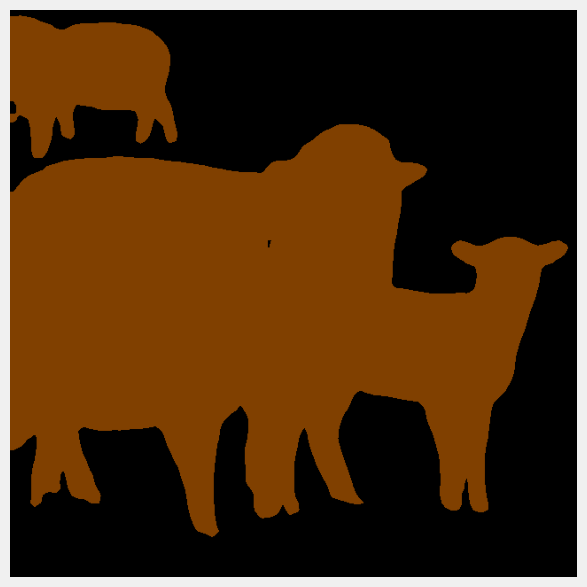

In [42]:
segment(fcn, os.path.join(inference_dir, r'sheep.png'))

## Deeplab v3

In [43]:
dlab = models.segmentation.deeplabv3_resnet101(weights = 'COCO_WITH_VOC_LABELS_V1').eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\jsrinivasan/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:16<00:00, 15.0MB/s] 


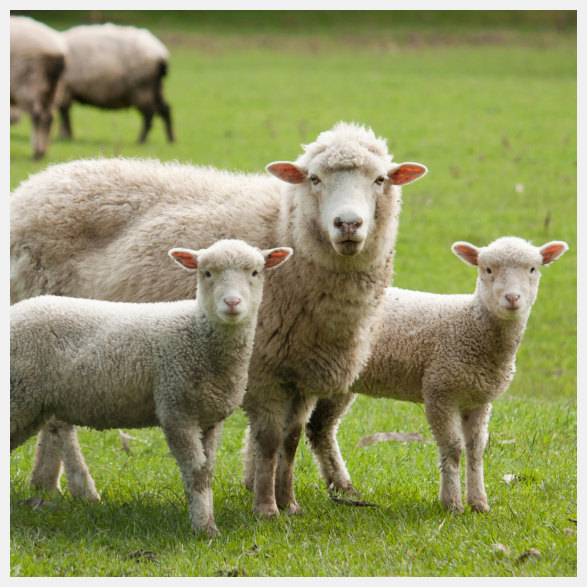

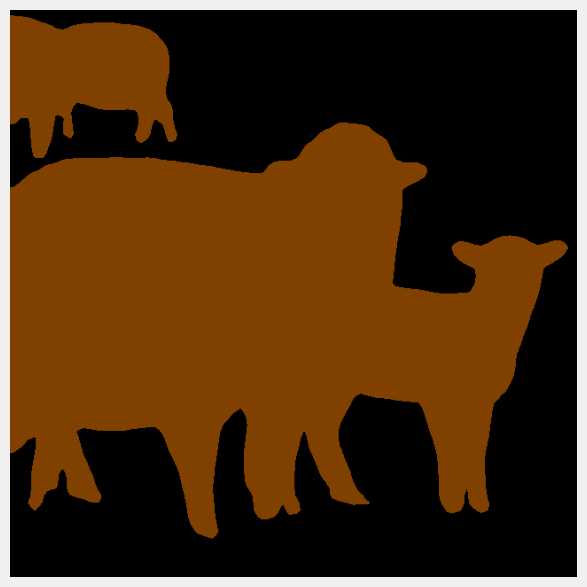

In [44]:
segment(dlab, os.path.join(inference_dir, r'sheep.png'))

In [47]:
def infer_time(net, path=os.path.join(inference_dir, 'bird.jpg'), dev='cuda'):
    img = Image.open(path)
    trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

    inp = trf(img).unsqueeze(0).to(dev)

    st = time.time()
    out1 = net.to(dev)(inp)
    et = time.time()

    return et - st

In [48]:
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [0.5273663997650146, 0.250105619430542, 0.2602345943450928, 0.29317259788513184, 0.2508277893066406, 0.25708723068237305, 0.2667062282562256, 0.27991628646850586, 0.2636277675628662, 0.25925731658935547]
Inference time for first few calls for DeepLabv3: [0.6517782211303711, 0.2987534999847412, 0.29039955139160156, 0.2922391891479492, 0.29645466804504395, 0.32090139389038086, 0.3280937671661377, 0.3159911632537842, 0.31432199478149414, 0.30701637268066406]
The Average Inference time on FCN is:     0.28s
The Average Inference time on DeepLab is: 0.28s


In [49]:
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_gpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_gpu[:10]))

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

Inference time for first few calls for FCN      : [0.8303024768829346, 0.35883045196533203, 0.015155553817749023, 0.016162872314453125, 0.014211416244506836, 0.016338825225830078, 0.01700592041015625, 0.35564208030700684, 0.017553091049194336, 0.15500807762145996]
Inference time for first few calls for DeepLabv3: [0.2015681266784668, 0.016344070434570312, 0.014570951461791992, 0.05673623085021973, 0.013971328735351562, 0.015727758407592773, 0.08943009376525879, 0.017452716827392578, 0.03436160087585449, 0.07402181625366211]
The Average Inference time on FCN is:     0.146s
The Average Inference time on DeepLab is: 0.140s


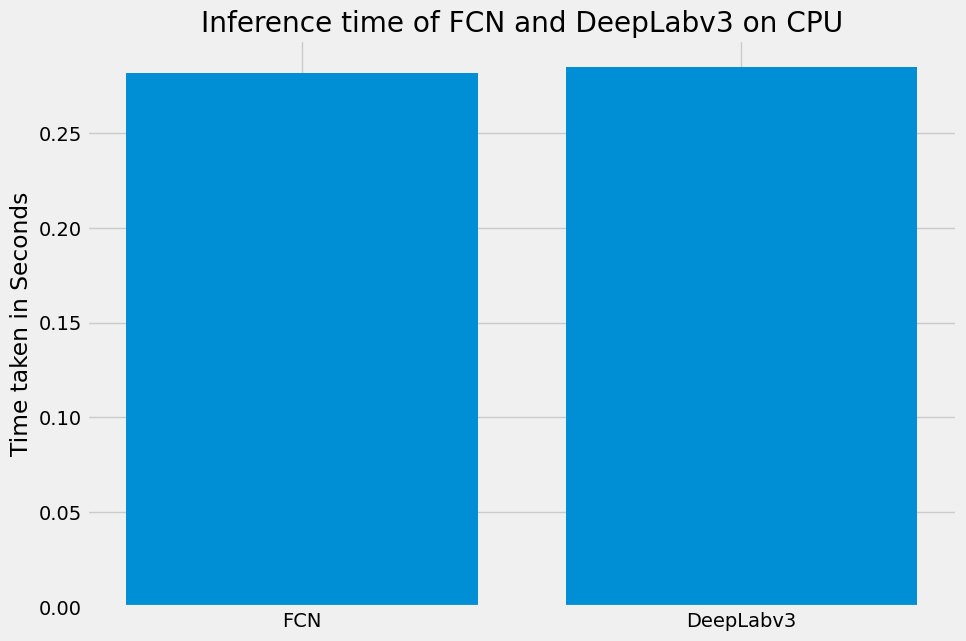

In [50]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()

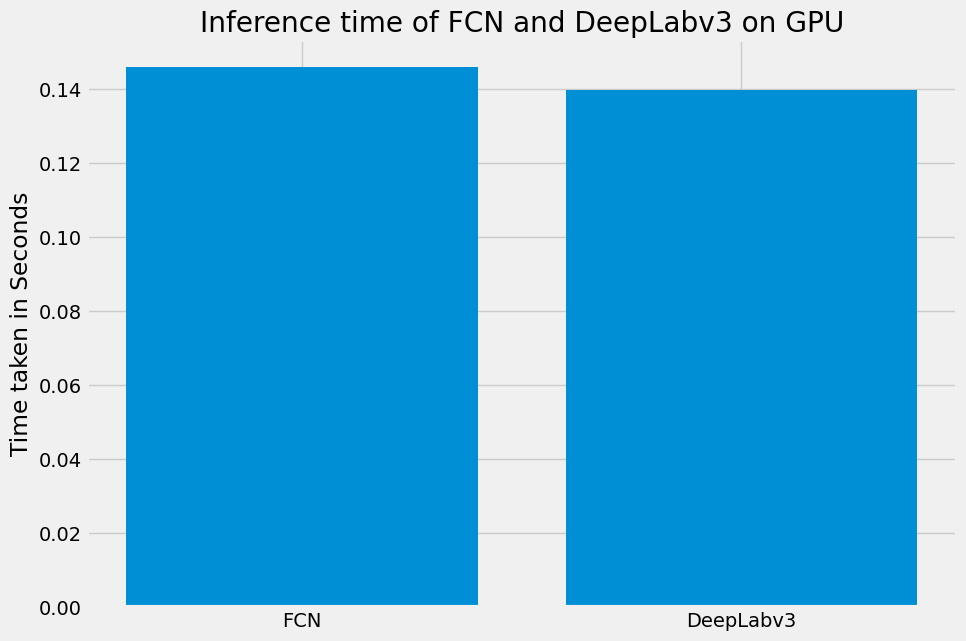

In [51]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on GPU')
plt.show()